#Digit recognition with the MNIST dataset
---
###Let's set up our environment

In [7]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import numpy.ma as ma
import time
import math

from PIL import Image, ImageOps
from sklearn.datasets import fetch_mldata

###Now let's get our functions from datamicroscopes

In [8]:
from microscopes.models import bb as beta_bernoulli
from microscopes.mixture.definition import model_definition
from microscopes.common.rng import rng
from microscopes.common.recarray.dataview import numpy_dataview
from microscopes.mixture import model, runner, query
from microscopes.kernels import parallel

##Let's focus on classifying 2's and 3's

In [9]:
mnist_dataset = fetch_mldata('MNIST original')
Y_2 = mnist_dataset['data'][np.where(mnist_dataset['target'] == 2.)[0]]
Y_3 = mnist_dataset['data'][np.where(mnist_dataset['target'] == 3.)[0]]
print 'number of twos:', Y_2.shape[0]
print 'number of threes:', Y_3.shape[0]

number of twos: 6990
number of threes: 7141
number of twos: 6990
number of threes: 7141


###To pass our data into datamicroscopes, we first must munge the data into recarray format

In [10]:
_, D = Y_2.shape
W = int(math.sqrt(D))
assert W * W == D
Y = np.vstack([Y_2, Y_3])
Y = np.array([tuple(y) for y in np.random.permutation(Y)], dtype=[('', bool)]*D)

###Now, we can initialize our model

###To do so, we must:

1. Specify the number of chains
2. Import the data
3. Define the model
4. Initialize the model
5. Initialize the samplers, aka `runners`

In [11]:
nchains = 5
view = numpy_dataview(Y)
defn = model_definition(Y.shape[0], [beta_bernoulli]*D)
prng = rng()
kc = runner.default_kernel_config(defn)
latents = [model.initialize(defn, view, prng) for _ in xrange(nchains)]
runners = [runner.runner(defn, view, latent, kc) for latent in latents]
r = parallel.runner(runners)

##Now let's run each chain in parallel for 5 iterations

In [12]:
start = time.time()
iters = 5
r.run(r=prng, niters=iters)
print "mcmc took", (time.time() - start)/60., "minutes"

mcmc took 156.391473516 minutes
mcmc took 156.391473516 minutes


###To save our results, we can get the latest assignment of each observation and pickle the output

In [13]:
infers = r.get_latents()

In [14]:
# save to disk 
import pickle
with open("mnist-predictions-infers.pickle", 'w') as fp:
    pickle.dump(infers, fp)

In [15]:
import pickle
infers = pickle.load(open("mnist-predictions-infers.pickle"))

##With our saved results, we can plot our learned clusters

In [16]:
def plot_clusters(s, scalebysize=False):
    hps = [s.get_feature_hp(i) for i in xrange(D)]
    def prior_prob(hp):
        return hp['alpha'] / (hp['alpha'] + hp['beta'])
    def data_for_group(gid):
        suffstats = [s.get_suffstats(gid, i) for i in xrange(D)]
        def prob(hp, ss):
            top = hp['alpha'] + ss['heads']
            bot = top + hp['beta'] + ss['tails']
            return top / bot
        probs = [prob(hp, ss) for hp, ss in zip(hps, suffstats)]
        return np.array(probs)
    def scale(d, weight):
        im = d.reshape((W, W))
        newW = max(int(weight * W), 1)
        im = Image.fromarray(im)
        im = im.resize((newW, newW))
        im = ImageOps.expand(im, border=(W - newW) / 2)
        im = np.array(im)
        a, b = im.shape
        if a < W:
            im = np.append(im, np.zeros(b)[np.newaxis,:], axis=0)
        elif a > W:
            im = im[:W,:]
        if b < W:
            im = np.append(im, np.zeros(W)[:,np.newaxis], axis=1)
        elif b > W:
            im = im[:,:W]
        return im.flatten()
    def groupsbysize(s):
        counts = [(gid, s.groupsize(gid)) for gid in s.groups()]
        counts = sorted(counts, key=lambda x: x[1], reverse=True)
        return counts
    data = [(data_for_group(g), cnt) for g, cnt in groupsbysize(s)]
    largest = max(cnt for _, cnt in data)
    data = [scale(d, cnt/float(largest)) 
            if scalebysize else d for d, cnt in data]
    digits_per_row = 12
    rem = len(data) % digits_per_row
    if rem:
        fill = digits_per_row - rem
        for _ in xrange(fill):
            data.append(np.zeros(D))
    rows = len(data) / digits_per_row
    data = np.vstack([
        np.hstack([d.reshape((W, W)) for d in data[i:i+digits_per_row]]) 
        for i in xrange(0, len(data), digits_per_row)])
    plt.imshow(data, cmap=plt.cm.binary, interpolation='nearest')
    plt.show()

##Let's show all groups (also by size) for the first set of assignments

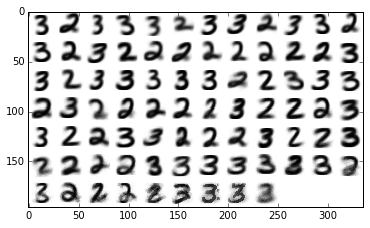

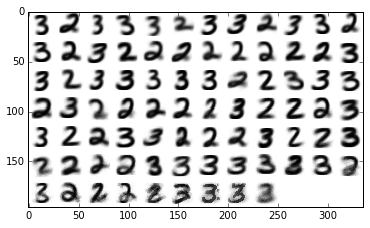

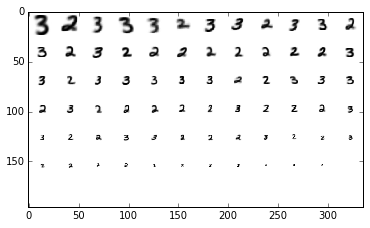

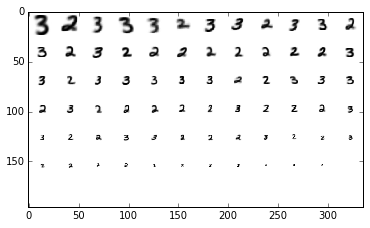

In [17]:
plt.hold(True)
plot_clusters(infers[0])
plot_clusters(infers[0], scalebysize=True)

##Now, let's used our learned clusters to make predictions when presented with only the top half of the digit image

In [18]:
present = D/2
absent = D-present
queries = [tuple(Y_2[i]) for i in np.random.permutation(Y_2.shape[0])[:4]] + \
          [tuple(Y_3[i]) for i in np.random.permutation(Y_3.shape[0])[:4]]

queries_masked = ma.masked_array(
    np.array(queries, dtype=[('',bool)]*D),
    mask=[(False,)*present + (True,)*absent])

statistics = query.posterior_predictive_statistic(queries_masked, infers, prng, samples_per_chain=10, merge='avg') 

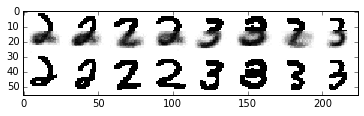

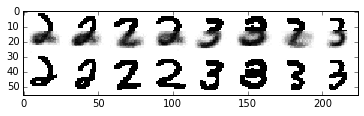

In [19]:
data0 = np.hstack([np.array(list(s)).reshape((W,W)) for s in statistics])
data1 = np.hstack([np.clip(np.array(q, dtype=np.float), 0., 1.).reshape((W, W)) for q in queries])
data = np.vstack([data0, data1])
plt.imshow(data, cmap=plt.cm.binary, interpolation='nearest')